# Part 2 - 2 Point Stats

## Overview

 - Continuous and categorical microstructure function

 - Artificial microstructures
 
 - 2 point stats
 
 - Dimensionality reduction
 
 - Dask
 
 - Classify microstructure

In [1]:
import numpy as np
from pymks.bases import PrimitiveBasis

In [2]:
?PrimitiveBasis

In [3]:
data_cat = np.array([[1, 2, 0]])

Use the primitive basis or microstructure function to discretise the data. This is the most straightforward basis to understand. 

$ m_k[h; s] = \delta[h - \phi_k[s]] $

$ \delta [x] = \max \left( 1 - \left|\frac{x}{\Delta h}\right|, 0 \right) $

In [4]:
basis = PrimitiveBasis(n_states=3, domain=[0, 2])
data_disc = basis.discretize(data_cat)

Discretizing the data adds a new index. The last index has the same length as `n_states`.

In [5]:
print(data_cat.shape)
print(data_disc.shape)

(1, 3)
(1, 3, 3)


Categorical data now has digital representation.

In [6]:
print(data_cat[0, 0])
print(data_disc[0, 0, :])

1
[ 0.  1.  0.]


Try this with continuous data.

In [7]:
data_con = np.array([[0.1, 0.5, 0.3]])

In [8]:
basis = PrimitiveBasis(n_states=5, domain=[0, 1])
data_disc = basis.discretize(data_con)

In [9]:
print(data_con.shape)
print(data_disc.shape)

(1, 3)
(1, 3, 5)


The continuous data varies between 0 and 1. This is a first order discretized $\delta$ function.

In [10]:
print(data_con[0, 0])
print(data_disc[0, 0])

0.1
[ 0.6  0.4  0.   0.   0. ]


Using a Legendre basis to discretize data. Legendre polynomials are good for this discretization because they are orthogonal with respect to the L2-norm

In [11]:
data_leg = np.array([[-0.5, 0.1, 0.9]])

In [12]:
from pymks.bases import LegendreBasis
basis = LegendreBasis(n_states=4, domain=[-1, 1])

In [13]:
data_disc = basis.discretize(data_leg)
print(data_disc.shape)

(1, 3, 4)


In [14]:
print(data_disc)

[[[ 0.5     -0.75    -0.3125   1.53125]
  [ 0.5      0.15    -1.2125  -0.51625]
  [ 0.5      1.35     1.7875   1.65375]]]


We can see how these are constructed using Scipy's `eval_legendre`.

In [15]:
from scipy.special import eval_legendre

In [16]:
eval_legendre(np.arange(4), -0.5) * (np.arange(4) + 0.5)

array([ 0.5    , -0.75   , -0.3125 ,  1.53125])

## Construct Artificial Microstructures

In [17]:
from pymks.datasets import make_microstructure

In [18]:
?make_microstructure

#### Use a Fourier Gaussian to create artificial microstructures. 
Fourier Gaussian comes from `numpy.ndimage`.

In [19]:
data = make_microstructure(grain_size=(20, 20))

By default 10 microstructures are generated with `make_microstructures`.

In [20]:
print(data.shape)

(10, 101, 101)


View the results using Matplotlib's `imshow`

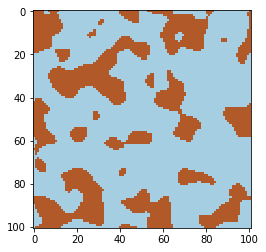

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Paired'

plt.imshow(data[0]);

## Fiber Microstructure

Construct a different microstructure using a fiber structure.

In [22]:
data_fiber = make_microstructure(grain_size=(95, 15))

View the results using `imshow`

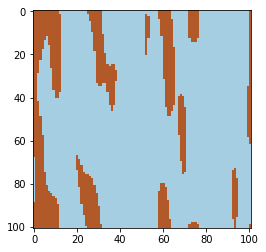

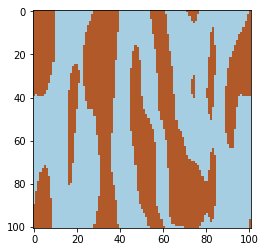

In [23]:
plt.imshow(data_fiber[0])
plt.show()
plt.imshow(data_fiber[1])
plt.show()

## 2 Point Stats

Construct 150 data sets with different structures

In [24]:
np.random.seed(0)

data_blob = make_microstructure(n_samples=50, grain_size=(30, 30))
data_fiber_v = make_microstructure(n_samples=50, grain_size=(100, 10))
data_fiber_h = make_microstructure(n_samples=50, grain_size=(10, 100))

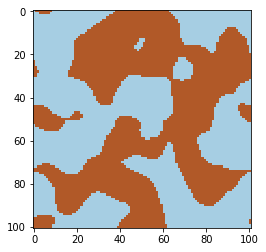

In [25]:
plt.imshow(data_blob[2]);

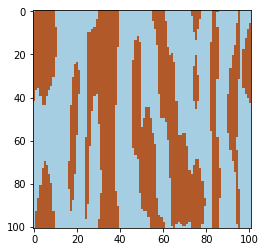

In [26]:
plt.imshow(data_fiber_v[1]);

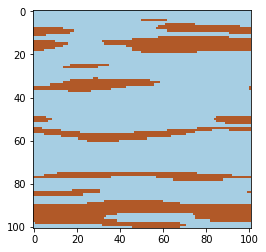

In [27]:
plt.imshow(data_fiber_h[0]);

In [28]:
data_fiber_v.shape

(50, 101, 101)

Concatenate our data into a single array.

In [29]:
data = np.concatenate([data_blob, data_fiber_v, data_fiber_h], axis=0)

In [30]:
data.shape

(150, 101, 101)

View all the data using subplots with Matplotlib

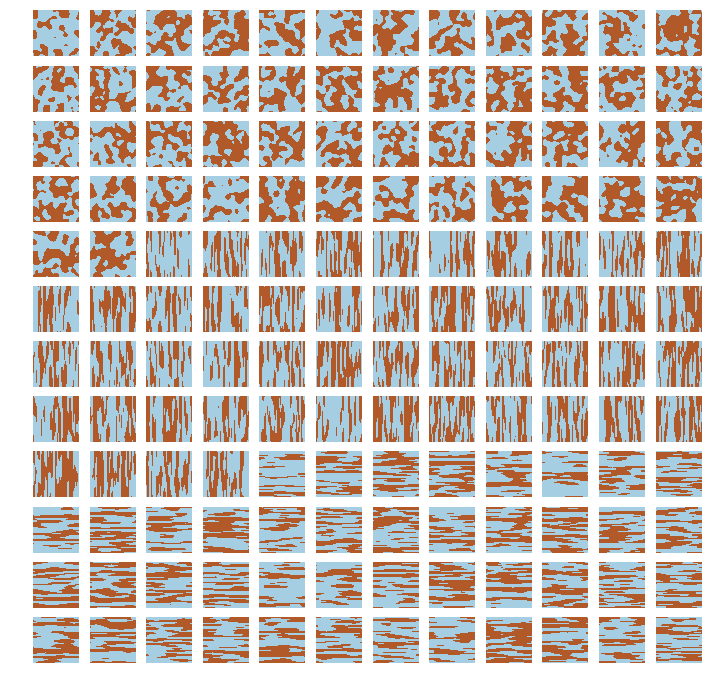

In [31]:
fig = plt.figure(figsize=(12, 12))
for i in range(12):
    for j in range(12):
        count = i * 12 + j
        ax = fig.add_subplot(12, 12, count + 1)
        ax.set_aspect('equal')
        img = plt.imshow(data[count])
        plt.axis('off')
        img.set_cmap('Paired')

# 2 Point Stats

**Use convolutions to construct the 2 point stats across each state space pairing. This is quite fast in Fourier space.**

In [32]:
from pymks.stats import correlate

basis = PrimitiveBasis(n_states=2, domain=[0, 1])
data_corr = correlate(data, basis=basis)

In [33]:
data_corr.shape

(150, 101, 101, 3)

**The two point stats reflect the shape of the structures**


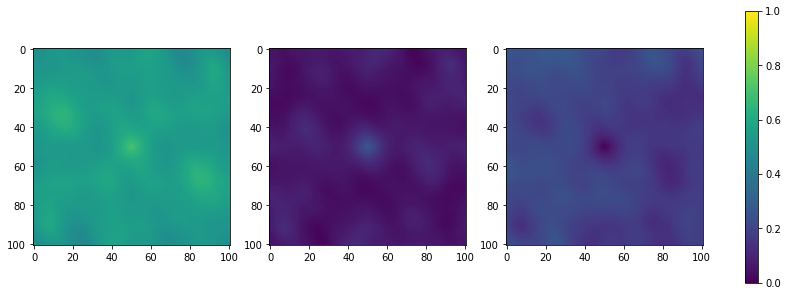

In [34]:
fig, axs = plt.subplots(1, 3)

for i, ax in enumerate(axs):
    im = ax.imshow(data_corr[0, :, :, i], vmin=0.0, vmax=1.0, cmap="viridis")
fig.set_size_inches(15, 5)
fig.colorbar(im, ax=axs.ravel().tolist());

In [35]:
print(data_corr[0, :, :, 0] + data_corr[0, :, :, 1] + data_corr[0, :, :, 2] + data_corr[0, ::-1, ::-1, 2])

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


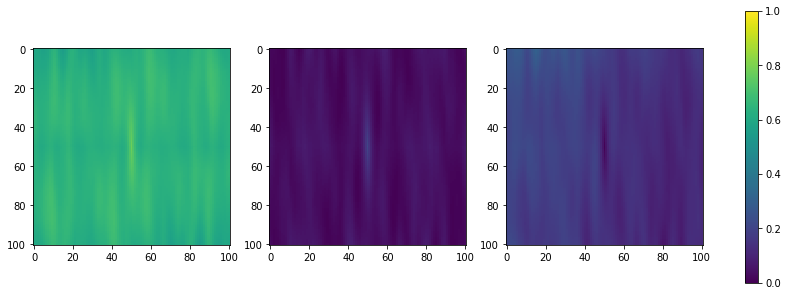

In [36]:
fig, axs = plt.subplots(1, 3)

for i, ax in enumerate(axs):
    im = ax.imshow(data_corr[50, :, :, i], vmin=0.0, vmax=1.0, cmap="viridis")
fig.set_size_inches(15, 5)
fig.colorbar(im, ax=axs.ravel().tolist());

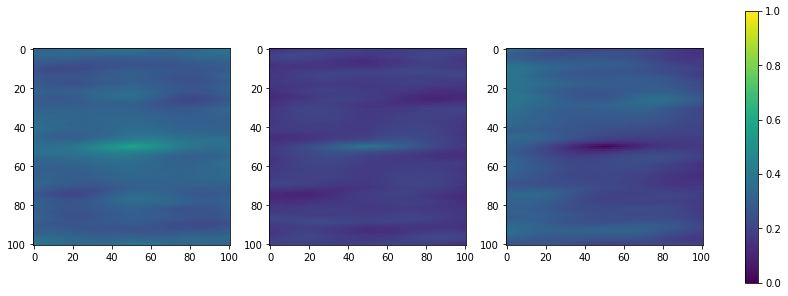

In [37]:
fig, axs = plt.subplots(1, 3)

for i, ax in enumerate(axs):
    im = ax.imshow(data_corr[-1, :, :, i], vmin=0.0, vmax=1.0, cmap="viridis")
fig.set_size_inches(15, 5)
fig.colorbar(im, ax=axs.ravel().tolist());

In [38]:
data_corr.shape

(150, 101, 101, 3)

## Dimensionality Reduction

We've created a huge number of features, over 30,000 per sample. We need to reduce those down to only a few features to do classification using `LogisticRegression`.

In [39]:
data_reshape = np.reshape(data_corr, (data_corr.shape[0], data_corr[0].size))

In [40]:
print(data_reshape.shape)

(150, 30603)


In [41]:
data_mean = data_reshape - np.mean(data_reshape, axis=1)[:, None]

In [43]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=5)

In [44]:
data_pca = pca_model.fit_transform(data_mean)

In [45]:
data_pca.shape

(150, 5)

/Users/apaarshanker/anaconda3/envs/mks-testbed/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


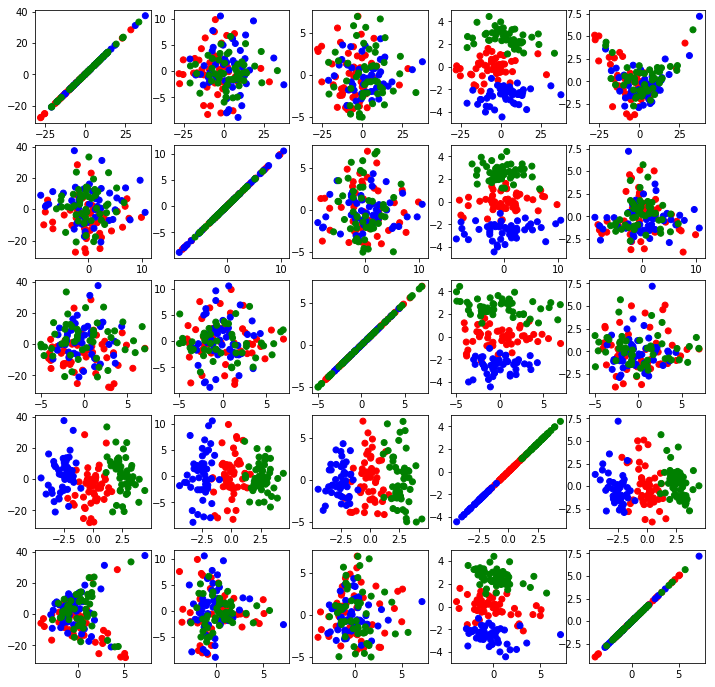

In [46]:
# NBVAL_IGNORE_OUTPUT

colors = ['r'] * 50 + ['b'] * 50 + ['g'] * 50

fig, axss = plt.subplots(5, 5)

for i, axs in enumerate(axss):
    for j, ax in enumerate(axs):
        ax.scatter(data_pca[:, i], data_pca[:, j], color=colors)
fig.set_size_inches(12, 12)
fig.show()

In [47]:
classification = np.concatenate([np.zeros(50), np.ones(50), np.ones(50) + 1]).astype(int)

In [49]:
# NBVAL_SKIP

from bqplot import pyplot as bq_plt

bq_plt.figure(title="PCA2 v PCA3")
bq_plt.scatter(data_pca[:, 2], data_pca[:, 3], color=classification)
bq_plt.show()

## Using Dask

**Speed it up using Dask. This is an embarissingly parallel operation that is easy to paralleliz**

In [50]:
# NBVAL_IGNORE_OUTPUT

%timeit correlate(data, basis=basis)

7.54 s ± 248 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
print(data.shape)

(150, 101, 101)


In [52]:
data_corr.shape

(150, 101, 101, 3)

In [53]:
import dask.array as da

data_da = da.from_array(data, chunks=(5, 101, 101))

print(data_da.shape)
print(data_da.chunks)

/Users/apaarshanker/anaconda3/envs/mks-testbed/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


(150, 101, 101)
((5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5), (101,), (101,))


In [55]:
# NBVAL_IGNORE_OUTPUT

import dask.threaded
import dask.multiprocessing

def correlate_(data_):
    basis = PrimitiveBasis(n_states=2, domain=[0, 1])
    return correlate(data_, basis=basis)

data_da = da.from_array(data, chunks=(5, 101, 101))

map_ = da.map_blocks(correlate_, data_da, new_axis=1)

%timeit map_.compute(scheduler="single-threaded")

6.98 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
# NBVAL_IGNORE_OUTPUT

%timeit map_.compute(num_workers=2, scheduler="processes")

5.47 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
# NBVAL_IGNORE_OUTPUT

%timeit map_.compute(num_workers=4, scheduler="processes")

3.15 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
# NBVAL_IGNORE_OUTPUT

%timeit map_.compute(scheduler="multiprocessing")

2.09 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
# NBVAL_IGNORE_OUTPUT

%timeit map_.compute(scheduler="threads")

1.29 s ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Classification

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
model = LogisticRegression(C=1)
model.fit(data_pca, classification)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
classification_pred = model.predict(data_pca)

In [69]:
# NBVAL_IGNORE_OUTPUT

from sklearn.metrics import confusion_matrix

confusion_matrix(classification, classification_pred)

array([[42,  4,  4],
       [ 2, 48,  0],
       [ 0,  0, 50]])

# Train Test Split

In [80]:
X, y = np.reshape(data, (data.shape[0], data[0].size)), classification

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [72]:
print(X_train.shape)

(112, 10201)


In [73]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2)
train_index, test_index = next(skf.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def transform(X):
    X_ = np.reshape(X, (X.shape[0],) + data[0].shape)
    basis = PrimitiveBasis(n_states=2, domain=[0, 1])
    X_ = correlate(X, basis=basis)
    X_ = np.reshape(X_, (X_.shape[0], X_[0].size))
    return X_ - np.mean(X_, axis=1)[:, None]
    
transformer = FunctionTransformer(transform)

model = Pipeline([('transformer', transformer),
                  ('pca', PCA(n_components=5)),
                  ('classifier', LogisticRegression())])

In [75]:
# NBVAL_IGNORE_OUTPUT

model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('transformer', FunctionTransformer(accept_sparse=False,
          func=<function transform at 0x12ad09950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [76]:
y_pred = model.predict(X_test)

In [77]:
# NBVAL_IGNORE_OUTPUT

mat = confusion_matrix(y_test, y_pred)
print(mat)

[[13  7  5]
 [ 0 25  0]
 [ 0  0 25]]


## Cross-validate

`cross_val_score` uses `StratifiedKFold` for labeled data

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(scores)

[ 0.9         0.93333333  0.86666667  0.96666667  0.9       ]
